## Anomaly Detection- windowed method 

In [207]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout

Importing the dataset

In [208]:
data = pd.read_csv("data/realKnownCause/realKnownCause/machine_temperature_system_failure.csv",
                   parse_dates=True, index_col="timestamp")

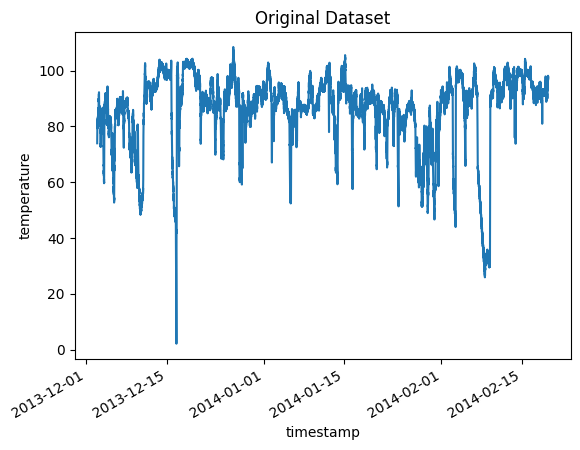

In [209]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
plt.ylabel("temperature")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [210]:
# Splitting to train and test
test_ratio =0.3
start = int(len(data) * 0.25 )  # or 0 
tr_data = data.iloc[start: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]

In [211]:
tr_data

,value
timestamp,
2013-12-22 14:00:00,87.168898
2013-12-22 14:05:00,87.933798
2013-12-22 14:10:00,85.804768
2013-12-22 14:15:00,85.955663
2013-12-22 14:20:00,86.815269
...,...
2014-01-26 23:40:00,88.470506
2014-01-26 23:45:00,88.395883
2014-01-26 23:50:00,88.608302


Normailzing the training set 

In [212]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 10213


Function to create the windowed data

In [213]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [214]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (9926, 288, 1)


VAE model

In [215]:
# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

In [216]:
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Reshape inputs to have the same shape
        x = tf.reshape(x, tf.shape(x_decoded_mean))
        # compute the average MSE error, then scale it up, i.e. simply sum on all axes
        reconstruction_loss = tf.reduce_sum(tf.square(x - x_decoded_mean))
        # compute the KL loss
        kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # return the average loss over all 
        total_loss = tf.reduce_mean(reconstruction_loss + 0.05*kl_loss)    
        self.add_loss(total_loss)
        return x  # Dummy output


In [217]:
model = keras.Sequential(
    [
        layers.Input(shape=(train.shape[1], train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_102            │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_103            │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_104            │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [218]:
history = model.fit(
    train,
    train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

Epoch 1/50


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.4848 - val_loss: 0.0318
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0457 - val_loss: 0.0194
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0307 - val_loss: 0.0168
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0228 - val_loss: 0.0151
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0190 - val_loss: 0.0164
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0166 - val_loss: 0.0168
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0152 - val_loss: 0.0217
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0143 - val_loss: 0.0263
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0136 - val_loss: 0.0267
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0130 - val_loss: 0.0304
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0421
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0122 - val_l

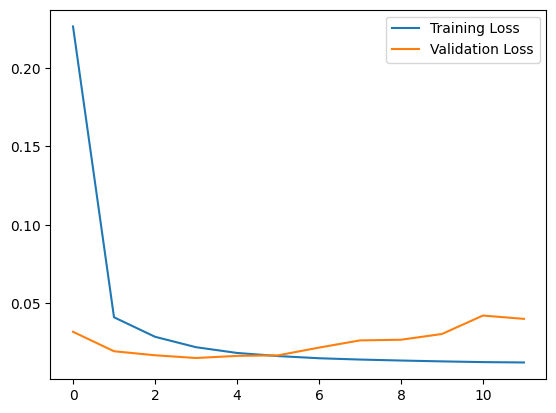

In [219]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

311/311 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


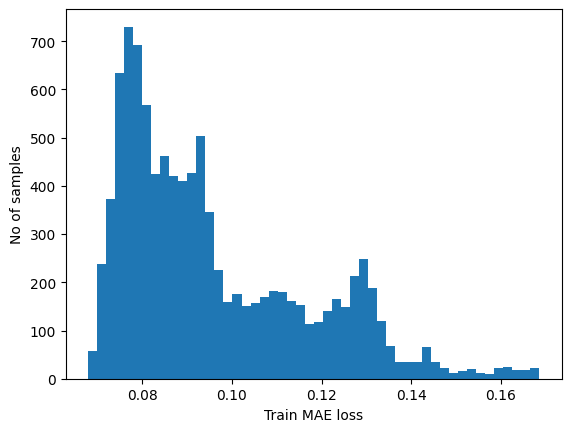

Reconstruction error threshold:  0.16851004171351958


In [220]:
# Get train MAE loss.
train_pred = model.predict(train)
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

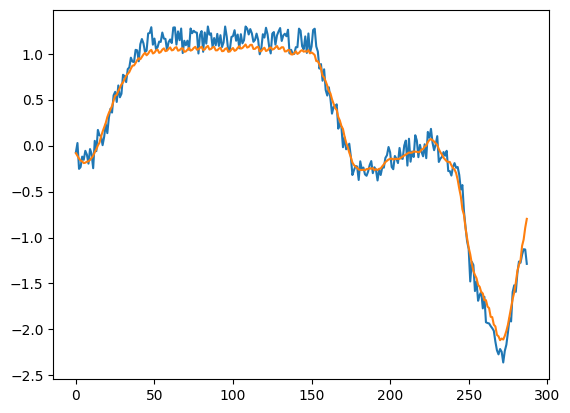

In [221]:
# Checking how the first sequence is learnt
plt.plot(train[0])
plt.plot(train_pred[0])
plt.show()

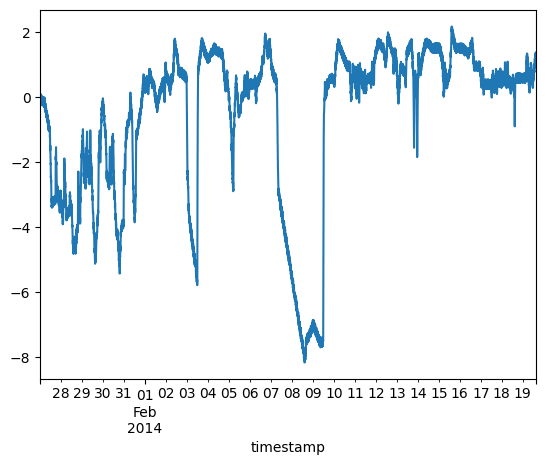

Test input shape:  (6522, 288, 1)
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


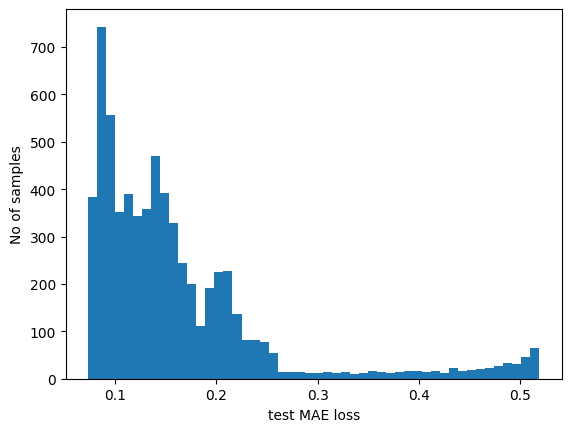

Number of anomaly samples:  2043
Indices of anomaly samples:  (array([  48,   49,   50, ..., 5644, 5645, 5646], dtype=int64),)


In [222]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = model.predict(test)
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [223]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_scaled) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [224]:
data['label'] = 1
instances= [["2013-12-10 06:25:00","2013-12-12 05:35:00"],
            ["2013-12-15 17:50:00","2013-12-17 17:00:00"],
            ["2014-01-27 14:20:00","2014-01-29 13:30:00"],
            ["2014-02-07 14:55:00","2014-02-09 14:05:00"]]


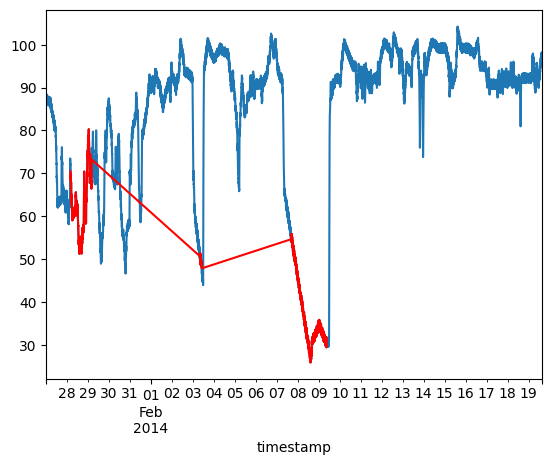

In [225]:
df_subset = tst_data.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()